# Import các module

In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

from collections import Counter
import matplotlib.pyplot as plt

# Load data

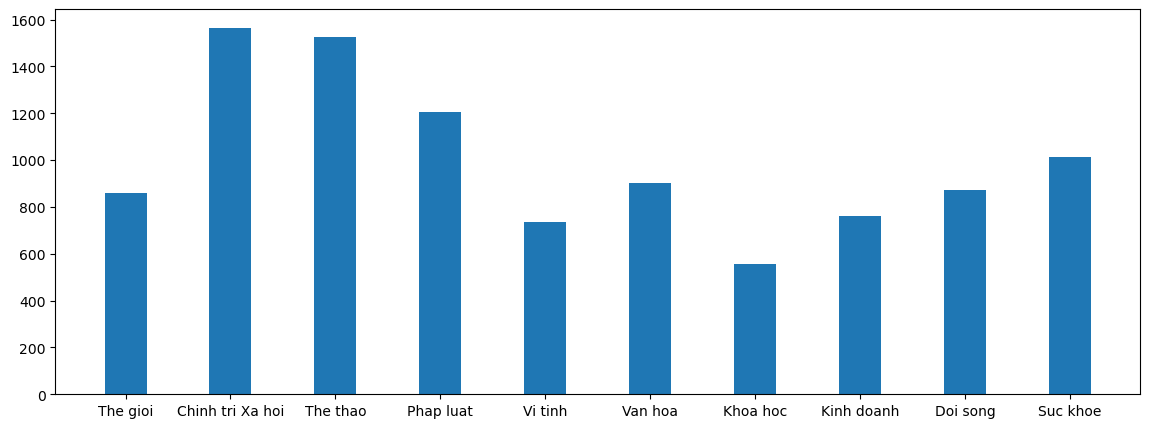

In [14]:
ROOT_PATH = '/kaggle/input/news-vi'
train_path = 'train.csv'
# tổng có 33759 dòng trong file
train_df = pd.read_csv(os.path.join(ROOT_PATH, train_path), index_col=0).sample(frac=1)[:10000]

# Thống kê các lớp
train_labels = train_df['label'].values
train_texts = train_df['text'].values

# Vẽ đồ thị thể hiện các lớp
x = dict(Counter(train_labels)).keys()
height = dict(Counter(train_labels)).values()
plt.figure(figsize=(14,5))
plt.bar(x=x, height=height, width=0.4)
plt.show()

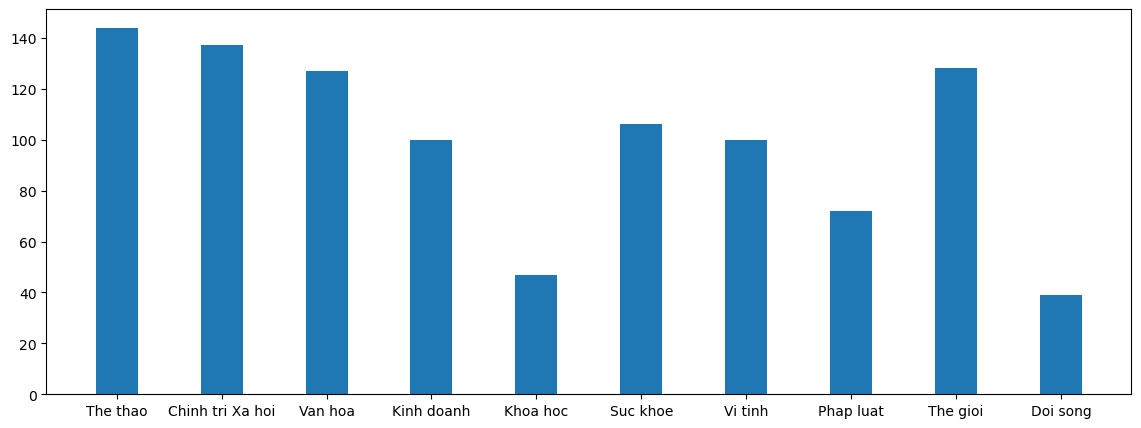

In [15]:
# load data test
test_path = 'test.csv'
test_df = pd.read_csv(os.path.join(ROOT_PATH, test_path), index_col=0).sample(frac=1)[:1000]

test_labels = test_df['label'].values
test_texts = test_df['text'].values

# Vẽ đồ thị thể hiện các lớp
x = dict(Counter(test_labels)).keys()
height = dict(Counter(test_labels)).values()
plt.figure(figsize=(14,5))
plt.bar(x=x, height=height, width=0.4)
plt.show()

# Chuẩn hóa dữ liệu từ văn bản thành số

### Chuẩn hóa labels

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(train_labels)
y_train = le.transform(train_labels)
y_test = le.transform(test_labels)

### Chuẩn hóa văn bản

In [17]:
from transformers import AutoTokenizer
# Tokenizer để encode đầu vào văn bản
tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
# In ra độ dài tối đa và độ dài trung bình giữa các câu
avg = 0
maximum = 0
for sent in train_texts:
    length = len(sent.split())
    avg += length
    maximum = max(length, maximum)
print(maximum)
print(avg/len(train_texts))

13090
383.9812


In [19]:
MAX_LEN = 256 # dùng 256 từ để phân loại văn bản

In [20]:
train_ids = tokenizer(list(train_texts), max_length=MAX_LEN, padding='max_length', truncation=True, return_attention_mask=False, return_token_type_ids=False).input_ids # truncation là để cắt bỏ bớt phần dài hơn max_length
test_ids = tokenizer(list(test_texts), max_length=MAX_LEN, padding='max_length', truncation=True, return_attention_mask=False, return_token_type_ids=False).input_ids

In [21]:
X_train = np.asarray(train_ids)
X_test = np.asarray(test_ids)

# Tạo model

In [22]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates
# positional Encoding
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

# TokenEmbedding
class TokenEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model, 
                    input_vocab_size, # tokenizer.vocab_size
                    max_length): # max_seq_length - MAX_LENGTH
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_length, d_model)

    def call(self, x): # x(batch_size, input_seq_len)
        seq_len = tf.shape(x)[1]
        # cộng token embedding và position encoding
        x = self.embedding(x)  # x(batch_size, input_seq_len, d_model), Input Embedding
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        pos_enc = self.pos_encoding[:, :seq_len, :] # Positional Encoding   

        return x + pos_enc


# Encoder
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        # sử dụng multi-head attention để tìm sự liên kết giữa các từ trong câu
        self.att = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads)

        self.ffn = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model)
        ])

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training):
        # sub layer 1
        attn_output = self.att(x, x)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        # sub layer 2
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        # return output
        return out2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
        super(Encoder, self).__init__()

        self.num_layers = num_layers
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

    def call(self, x, training=False): # (batch_size, input_seq_len)
        # adding embedding and position encoding.
        # x = self.token_emb(x)  # (batch_size, input_seq_len, d_model)
        for i in range(self.num_layers):
              x = self.enc_layers[i](x, training)
              # x = tf.math.add(x, self.enc_layers[i](x, training, mask))

        return x  # (batch_size, input_seq_len, d_model)

class EncoderModel():
    def __init__(self, num_class, num_layers, d_model, num_heads, dff, input_vocab_size, max_length, rate=0.1):
        # Khởi tạo tầng Embedding
        self.token_emb = TokenEmbedding(d_model, input_vocab_size, max_length)

        self.enc = Encoder(num_layers, d_model, num_heads, dff, rate)

        self.pooling = tf.keras.layers.GlobalMaxPooling1D()

        self.fnn = tf.keras.Sequential([
          tf.keras.layers.Dense(d_model, activation='relu'),
          tf.keras.layers.Dropout(rate),
          tf.keras.layers.Dense(num_class, activation='softmax')
        ])

    def create_model(self, training=False): # (batch_size, seq_len)
        inp = tf.keras.layers.Input(shape = (None, ), dtype=tf.int32)
        x = self.token_emb(inp) # (batch_size, seq_len, d_model)
        x = self.enc(x, training)
        pool = self.pooling(x)
        out = self.fnn(pool)
        return tf.keras.Model(inputs=inp, outputs=out)

In [25]:
# Config
num_class = len(Counter(y_train))
num_layers = 12
d_model = 512
num_heads = 8
dff = 512
input_vocab_size = tokenizer.vocab_size
max_length = MAX_LEN
rate = 0.1

model = EncoderModel(
    num_class,
    num_layers,
    d_model,
    num_heads,
    dff,
    input_vocab_size,
    max_length,
    rate
).create_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 token_embedding_2 (TokenEmb  (None, None, 512)        32768000  
 edding)                                                         
                                                                 
 encoder_2 (Encoder)         (None, None, 512)         107145216 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 sequential_38 (Sequential)  (None, 10)                267786    
                                                                 
Total params: 140,181,002
Trainable params: 140,181,002
Non

In [26]:
adam = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=8, batch_size=16)    

Epoch 1/8
625/625 [==============================] - 503s 667ms/step - loss: 2.2044 - accuracy: 0.2024
Epoch 2/8
625/625 [==============================] - 414s 662ms/step - loss: 1.3586 - accuracy: 0.4922
Epoch 3/8
625/625 [==============================] - 414s 662ms/step - loss: 0.7646 - accuracy: 0.7436
Epoch 4/8
625/625 [==============================] - 413s 661ms/step - loss: 0.4683 - accuracy: 0.8504
Epoch 5/8
625/625 [==============================] - 413s 661ms/step - loss: 0.3083 - accuracy: 0.9047
Epoch 6/8
625/625 [==============================] - 413s 661ms/step - loss: 0.2128 - accuracy: 0.9341
Epoch 7/8
625/625 [==============================] - 413s 660ms/step - loss: 0.1540 - accuracy: 0.9557
Epoch 8/8
625/625 [==============================] - 413s 660ms/step - loss: 0.1297 - accuracy: 0.9607


In [27]:
# hàm để tính đô chính xác trên cả tập train và tập test
loss, accuracy = model.evaluate(X_train, y_train, verbose=False  
print("Training Accuracy: {:.4f}".format(accuracy))   
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9691
Testing Accuracy:  0.8180


In [28]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_pred, y_test))

32/32 [==============================] - 15s 426ms/step
              precision    recall  f1-score   support

           0       0.67      0.77      0.72       119
           1       0.38      0.48      0.43        31
           2       0.77      0.51      0.61        71
           3       0.74      0.88      0.80        84
           4       0.92      0.69      0.79        96
           5       0.80      0.90      0.85        94
           6       0.84      0.88      0.86       123
           7       0.97      0.96      0.96       145
           8       0.90      0.88      0.89       130
           9       0.89      0.83      0.86       107

    accuracy                           0.82      1000
   macro avg       0.79      0.78      0.78      1000
weighted avg       0.83      0.82      0.82      1000



# Implement

In [34]:
data = pd.read_csv(os.path.join(ROOT_PATH, test_path), index_col=0).sample(frac=1)[:5]
data

,label,text
17338,Phap luat,thường_trú tại ấp long_thạnh a thị_trấn tân_ch...
25667,Suc khoe,hôm_nay tp hcm thực_hiện ca ghép gan thứ hai c...
45372,Van hoa,' trò_chuyện với hoa_hồng ' chuyện của một đời...
48186,Vi tinh,tin trên mạng có tuổi_thọ ngắn bạn có đọc bản ...
25417,Suc khoe,' sờ ' da cũng đoán được bệnh tim không mất tí...


In [35]:
actual_label = data['label'].values
pred_texts = data['text'].values

X_pred = tokenizer(list(pred_texts), max_length=MAX_LEN, padding='max_length', truncation=True).input_ids
X_pred = np.asarray(X_pred)
outputs = model.predict(X_pred)

pred_labels = np.argmax(outputs, axis=1)
pred_label = le.inverse_transform(pred_labels)

print('Nhãn dự đoán:', pred_label)
print('Nhãn thực tế: ',actual_label)

1/1 [==============================] - 0s 107ms/step
Nhãn dự đoán: ['Phap luat' 'Suc khoe' 'Van hoa' 'Vi tinh' 'Suc khoe']
Nhãn thực tế:  ['Phap luat' 'Suc khoe' 'Van hoa' 'Vi tinh' 'Suc khoe']
